In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import lmfit

# from bcqt-ctrl repo
# import helper_functions as hf

from pathlib import Path
from time import sleep, time
# from tqdm.auto import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
# only S21 dBm has factor of 20, otherwise it'd be a factor of 10
# this is because P = V^2/R, so the V^2 gives an extra factor of 2

def s21_dbm_to_lin(dbm_ampl):
    return np.log10(dbm_ampl) * 20  

def s21_lin_to_dbm(lin_ampl):
    return 10**(lin_ampl/20)

def load_all_csvs_in_path(path, key='*', idx=None):
    """AI is creating summary for load_all_csvs_in_path

    Args:
        path ([type]): [description]
        key (str, optional): [description]. Defaults to '*'.
        idx ([type], optional): [description]. Defaults to None.

    Returns:
        [type]: [description]
    """
    data_files = glob.glob(data_dir+key)
    
    if idx is not None:  # user wants to load a single file from dir
        idx = 0 if len(data_files) == 1 else idx  # set idx to 0 if there's only one file
        file = data_files[idx]
        df = pd.read_csv(file, sep=",", names=['Frequency','dBm','Phase'])
        freq = np.array(df['Frequency'])
        ampl = s21_lin_to_dbm(df['dBm'])
        phase = np.unwrap(np.deg2rad(df['Phase']))
        cmplx = ampl * np.exp(1j*phase)
        
        return freq, cmplx, df
    
    elif idx is None and len(data_files) != 1:  
        freq_dict, cmplx_dict, df_dict = {}, {}, {}
        for filepath in data_files:
            filename = os.path.basename(filepath)
            df = pd.read_csv(filepath, sep=",", names=['Frequency','dBm','Phase'])
            freq = np.array(df['Frequency'])
            ampl = s21_lin_to_dbm(df['dBm'])
            phase = np.unwrap(np.deg2rad(df['Phase']))
            cmplx = ampl * np.exp(1j*phase)
            
            freq_dict[filename] = freq
            cmplx_dict[filename] = cmplx
            df_dict[filename] = df
            
        return freq_dict, cmplx_dict, df_dict
        
    else:
        # idx is None and len(data_files) == 1
        print(f"idx={idx}, len(data_files)={len(data_files)}\n failed if & elif")
        raise
        

# load data from sample directory
data_dir = 'test_data/R0_Jorge/R0_Jorge/'
chosen_files = '*'
# display(glob.glob(data_dir+chosen_files))
freq, cmplx, df = load_all_csvs_in_path(data_dir, chosen_files, idx=1)
## cmplx is complex s21 data
print(freq, "\n", cmplx)


[5.85995747e+09 5.86000796e+09 5.86001176e+09 5.86001340e+09
 5.86001451e+09 5.86001549e+09 5.86001660e+09 5.86001824e+09
 5.86002204e+09 5.86007253e+09] 
 0   -0.007584-0.002081j
1   -0.008071-0.000061j
2   -0.006975+0.001866j
3   -0.004853+0.002437j
4   -0.003053+0.001460j
5   -0.002346-0.000217j
6   -0.002734-0.001863j
7   -0.003925-0.002980j
8   -0.005551-0.003269j
9   -0.007191-0.002524j
Name: dBm, dtype: complex128


## Testing scresonators

In [7]:
cur_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(cur_dir))

#For Zach
# this notebook is located in C:/Users/zachm/OneDrive/Documents/GitHub/zachmiles9/scresonators/test
# so the parent's parent directory is C:/Users/zachm/OneDrive/Documents/GitHub/zachmiles9
# and by adding that to our path, we can import C:/Users/zachm/OneDrive/Documents/GitHub/zachmiles9

#For Jorge
# this notebook is located in E:/GitHub/scresonators/test_ontebooks
# so the parent's parent directory is just E:/GitHub
# and by adding that to our path, we can import E:/GitHub/scresonators
sys.path.append(parent_parent_dir)
print(os.getcwd())

import scresonators.src as scres
print("\nimported scresonators!\n")


def print_dir(module, filter_underscore=True, text=""):
    if filter_underscore == True:
        print("showing dir({})".format(text))
        display( [i for i in dir(module) if '__' not in i] ) ## Display a list of modules if a dunder (double underscore) method like "__init__" is not included in the directory of the module?
    else:
        print("showing dir({})".format(text))
        display( dir(module) )


print_dir(scres.fit_methods.dcm, True, "src.fit_methods.dcm")
print_dir(scres.fit_methods.dcm.DCM, True, "src.fit_methods.dcm.DCM")

dcm_method = scres.fit_methods.dcm.DCM() ## Making an instance of DCM class. 
FitRes = scres.Fitter(dcm_method) ## Making instance of Fitter class.

w1 = freq[np.abs(cmplx).argmin()] 
init_guess = {
    'Q' : {'value' : 1e6, 'min' : 1e3, 'max' : 1e9},
    'Qc' : {'value' : 1e5, 'min' : 1e3, 'max' : 1e9},
    'w1' : {'value' : w1, 'min' : w1-3e3, 'max' : w1+3e3, 'vary' : True},
    'phi' : {'value' : 0.08, 'min' : -np.pi/2, 'max' : np.pi/2}, 
}

init_params = lmfit.create_params(**init_guess) # supplying each key and their values as kwargs
# * is for a list, ** is for a dictionary. These are unpacking operators. 
init_params.pretty_print() # method of params instance. params consists of parameter objects. This is the thing underneath where it says WARNING:root...
print() ## == print("\n") 

# underneath this table of parameters, we see stuff from 'verbose = True' starting with [[Model]]

amps = np.abs(cmplx)
db_amps = np.log10(amps) * 20

phases = np.angle(cmplx)
result, conf_intervals = FitRes.fit(freq, db_amps, phases, manual_init=init_params, verbose=True) ## set verbose=True if you want extra outputs including statistics

print(type(result))
fit_result_params = result.params


c:\Users\zachm\OneDrive\Documents\GitHub\zachmiles9\scresonators\test

imported scresonators!

showing dir(src.fit_methods.dcm)


['DCM', 'FitMethod', 'find_circle', 'lmfit', 'np']

showing dir(src.fit_methods.dcm.DCM)


['_abc_impl', 'create_model', 'find_initial_guess', 'func']

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q       1e+06     1000    1e+09     None     True     None     None
Qc      1e+05     1000    1e+09     None     True     None     None
phi      0.08   -1.571    1.571     None     True     None     None
w1   5.86e+09 5.86e+09 5.86e+09     None     True     None     None

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 72
    # data points      = 20
    # variables        = 4
    chi-square         = 2.13005223
    reduced chi-square = 0.13312826
    Akaike info crit   = -36.7917155
    Bayesian info crit = -32.8087864
    R-squared          = (-7.706438023151746-0.21502087969414949j)
[[Variables]]
    Q:    1129617.28 +/- 462563.768 (40.95%) (init = 1000000)
    Qc:   1062367.58 +/- 353079.643 (33.24%) (init = 100000)
    w1:   5.8600e+09 +/- 1334.36622 (0.00%) (init = 5.860015e+09)
    phi:  1.26563575 +/- 0.33229041 (26.25%) (init = 0.08)
[[Correlations]] (un

c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:317: UserWarning: Bound reached with prob(Q=1000.0) = 0.9930736227233877 < max(sigmas)
  warn(errmsg)
c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:317: UserWarning: Bound reached with prob(w1=5860012491.0) = 0.0 < max(sigmas)
  warn(errmsg)
c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:330: UserWarning: rel_change=-0.002638490910486017 < 1e-05 at iteration 4 and prob(w1=5860017828.464871) = 0.9930689935375343 < max(sigmas)
  warn(errmsg)
c:\Users\zachm\miniforge3\envs\scres2\lib\site-packages\lmfit\confidence.py:317: UserWarning: Bound reached with prob(phi=1.5707963267948966) = 0.8896534492916129 < max(sigmas)
  warn(errmsg)


        99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 Q  :      -inf-708816.03165-246249.368481129617.27584+539796.07685+1426900.32694+4807375.59083
 Qc :-1060997.65636-553906.48091-166355.767121062367.57897+416052.86378+1235093.55328+4083127.20442
 w1 :      -inf      -inf      -inf5860012491.00000+464.45025+2319.25439      +inf
 phi:  -1.25647  -0.65310  -0.24573   1.26564  +0.18592      +inf      +inf
<class 'lmfit.model.ModelResult'>


Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q    1.13e+06     1000    1e+09 4.626e+05     True     None     None
Qc   1.062e+06     1000    1e+09 3.531e+05     True     None     None
phi     1.266   -1.571    1.571   0.3323     True     None     None
w1   5.86e+09 5.86e+09 5.86e+09     1334     True     None     None
40.948715832764464 1129617.2758436406 462563.76828302746

abs(data):  0    0.007865
1    0.008072
2    0.007220
3    0.005431
4    0.003384
5    0.002356
6    0.003309
7    0.004928
8    0.006442
9    0.007621
Name: dBm, dtype: float64
abs(result):  [1.04713762 1.41281434 1.40911557 0.89602926 0.56854592 0.45473891
 0.47369928 0.56820678 0.72155438 0.95574673]


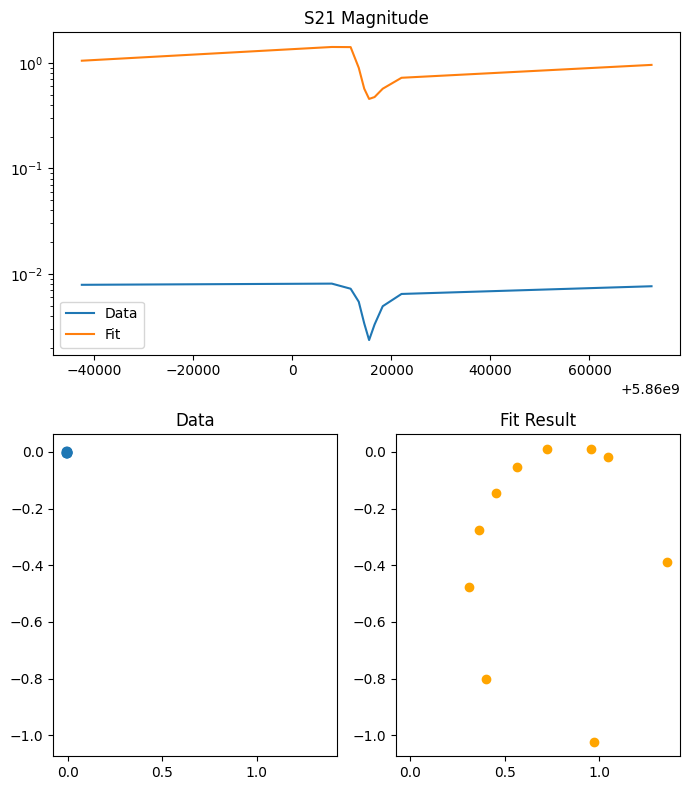

In [4]:
fit_result_params.pretty_print()

y_fit = result.eval(params=fit_result_params, x=freq)
# y_fit_err = result.eval_uncertainty()
Q_val = fit_result_params["Q"].value
Q_err = fit_result_params["Q"].stderr
dQ = 100 * Q_err/Q_val
print(dQ, Q_val, Q_err)

print("\nabs(data): ", np.abs(cmplx))
print("abs(result): ", np.abs(y_fit))

##########################################
#############    plotting   ##############
##########################################

mosaic = "AAAA\n BBCC"
fig, axes = plt.subplot_mosaic(mosaic, figsize=(7,8))
ax1, ax2, ax3 = axes["A"], axes["B"], axes["C"]
ax2.sharex(ax3)
ax2.sharey(ax3)

ax1.plot(freq, np.abs(cmplx), label="Data")
ax1.plot(freq, np.abs(y_fit), label="Fit")
ax1.set_yscale("log")
ax1.legend()
ax1.set_title("S21 Magnitude")

ax2.plot(np.real(cmplx), np.imag(cmplx), label="Data", linestyle='', marker='o')
ax2.set_title("Data")

ax3.plot(np.real(y_fit), np.imag(y_fit), label="Fit", linestyle='', marker='o', color='orange')
ax3.set_title("Fit Result")


fig.tight_layout()

## Multiple Resonators

to be implemented

In [5]:
# # load data from Andre
# data_dir = './samples/R0_Jorge/'
# chosen_files = '*'

# freq_dict, cmplx_dict = load_csv(data_dir, chosen_files, idx=None)

# dQ_list, Q_list = [], []

# print(f"# of resonators: {len(freq_dict)}")

# for freq, cmplx in zip(freq_dict.values(), cmplx_dict.values()):

#     FitRes = scres.Fitter(scres.fit_methods.DCM)

#     w1 = freq[np.abs(cmplx).argmin()]
#     init_guess = {
#         'Q' : {'value' : 1e6, 'min' : 1e3, 'max' : 1e9},
#         'Qc' : {'value' : 1e5, 'min' : 1e3, 'max' : 1e9},
#         'w1' : {'value' : w1, 'min' : w1-3e3, 'max' : w1+3e3, 'vary' : True},
#         'phi' : {'value' : 0.08, 'min' : -np.pi/2, 'max' : np.pi/2}, 
#     }

#     init_params = lmfit.create_params(**init_guess)

#     amps = np.abs(cmplx)
#     db_amps = np.log10(amps) * 20

#     phases = np.angle(cmplx)
#     result, conf_intervals = FitRes.fit(freq, db_amps, phases, manual_init=init_params, verbose=True)

#     fit_params = result.params
        
#     y_fit = result.eval(params=fit_params, x=freq)
#     # y_fit_err = result.eval_uncertainty()
#     Q_val = fit_params["Q"].value
#     Q_err = fit_params["Q"].stderr
#     dQ = 100 * Q_err/Q_val
#     print(dQ, Q_val, Q_err)
    
#     dQ_list.append(dQ)
#     Q_list.append(Q_val)


    

In [6]:
# for dQ, Q in zip(dQ_list, Q_list):
    
#     print(f"{dQ:1.2f}, {Q:1.2f}")

# fig, axes = plt.subplots(2,1, figsize=(7,8), sharex=True)
# ax1, ax2 = axes[0], axes[1]

# ax1.plot(dQ_list, 'ro', label="dQ")
# ax1.set_title(r"dQ Values  ($dQ=100 * dQ/\sigma dQ$)")

# ax2.plot(Q_list, 'bo', label="Fit")
# ax2.set_title("Q Values")

# ax2.set_xlabel("Resonator #")